## 1.0 Setup

### 1.1 Imports

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.fft as fft
import csv as csv

### 1.2 Constants

In [2]:
electrode_names = [
    "FP1", "FPz", "FP2", "AFp1", "AFPz", "AFp2", "AF7", "AF3", "AF4", "AF8",
    "AFF5h", "AFF1h", "AFF2h", "AFF6h", "F9", "F7", "F5", "F3", "F1", "Fz",
    "F2", "F4", "F6", "F8", "F10", "FFT9h", "FFT7h", "FFC5h", "FFC3h", "FFC1h",
    "FFC2h", "FFC4h", "FFC6h", "FFT8h", "FFT10h", "FT9", "FT7", "FC5", "FC3",
    "FC1", "FCz", "FC2", "FC4", "FC6", "FT8", "FT10", "FTT9h", "FTT7h", "FCC5h",
    "FCC3h", "FCC1h", "FCC2h", "FCC4h", "FCC6h", "FTT8h", "FTT10h", "T7", "C5",
    "C3", "C1", "Cz", "C2", "C4", "C6", "T8", "TTP7h", "CCP5h", "CCP3h", "CCP1h",
    "CCP2h", "CCP4h", "CCP6h", "TTP8h", "TP9", "TP7", "CP5", "CP3", "Cpz", "CP4",
    "CP6", "TP8", "TP10", "TPP9h", "TPP7h", "CPP5h", "CPP3h", "CPP1h", "CPP2h",
    "CPP4h", "CPP6h", "TPP8h", "TPP10h", "P9", "P7", "P5", "P3", "P1", "Pz", "P2",
    "P4", "P6", "P8", "P10", "PPO9h", "PPO5h", "PPO1h", "PPO2h", "PPO6h", "PPO10h",
    "PO9", "PO7", "PO3", "POz", "PO4", "PO8", "PO10", "POO9h", "POO1", "POO2",
    "POO10h", "O1", "Oz", "O2", "OI1h", "OI2h", "I1", "Iz", "I2"
]

sample_rate = 250 # Hz
sample_duration = 2 # s
num_electrodes = len(electrode_names)

num_electrodes

128

### 1.3 Load Example Signal for Testing

In [3]:
i = 0
for chunk in pd.read_csv('/kaggle/input/mindbigdata2023-mnist-8b/train.csv', chunksize=1):
    if i != 1:
        i += 1
        continue
    X = chunk.loc[:, 'FP1_0':'I2_499'].to_numpy()[0].reshape((128, 500))
    y = chunk['label'].to_numpy()
    break

y

array([5])

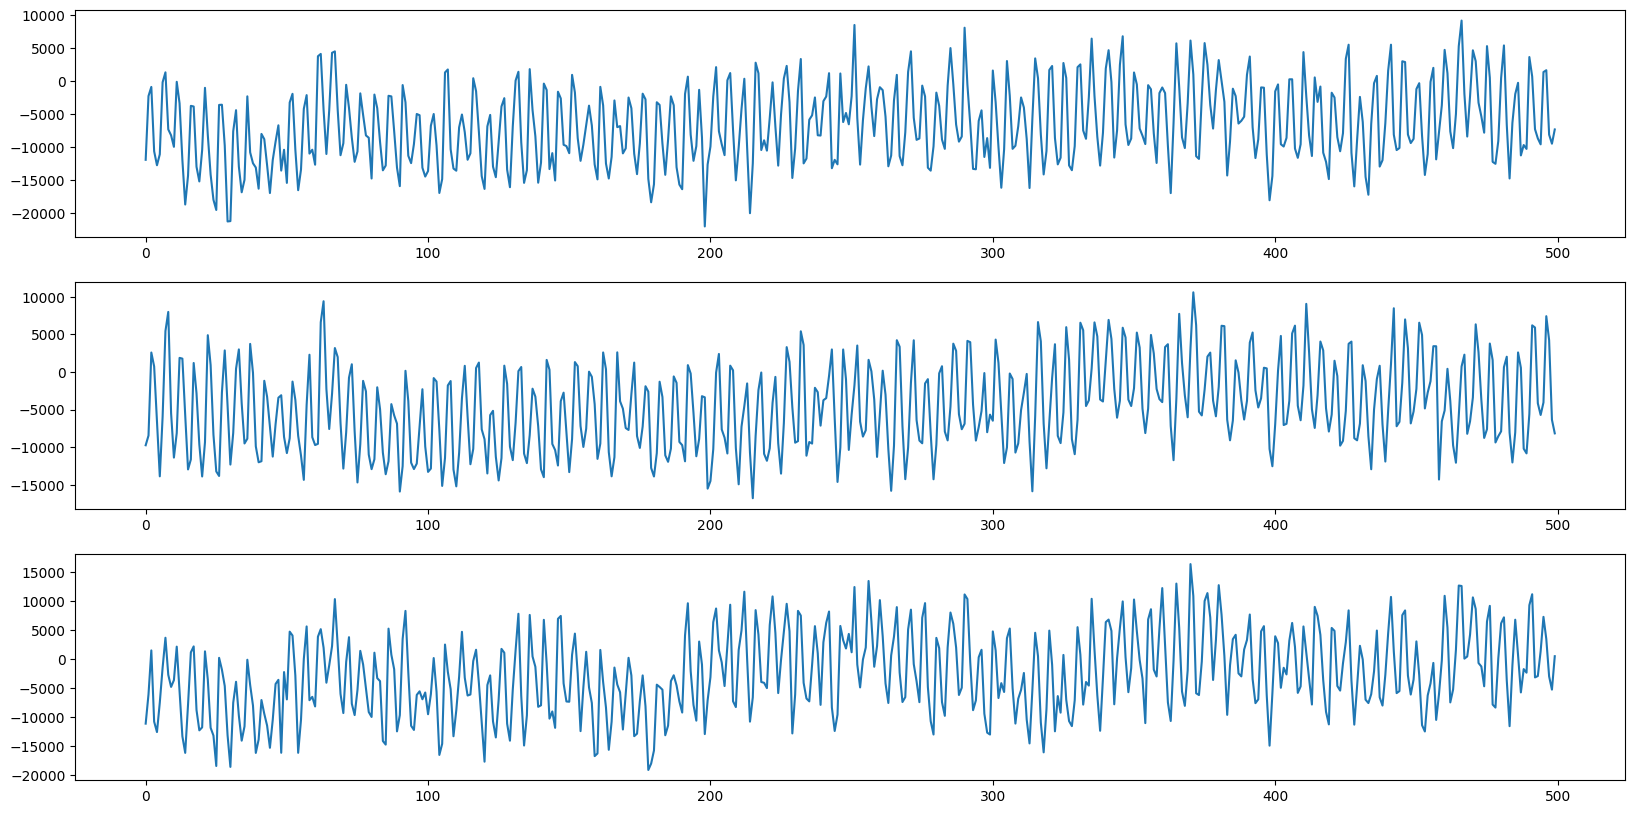

In [4]:
# plot the first three channels
fig, ax = plt.subplots(3,1, figsize=(20,10))
x = np.arange(500)
for i in range(len(ax)):
    ax[i].plot(x, X[i, :])
plt.show()

## 2.0 Preprocessing
### 2.1 Normalization

#### 2.1.0 Normalization function

In [5]:
def normalize(signals: np.array, low: float, high: float) -> np.array:
    """ Normalizes ALL signals by mapping `low` to -1 and `high` to 1"""
    signals_normed = (signals - low)/(high - low) * 2 - 1
    return signals_normed

#### 2.1.1 Normalization demonstration

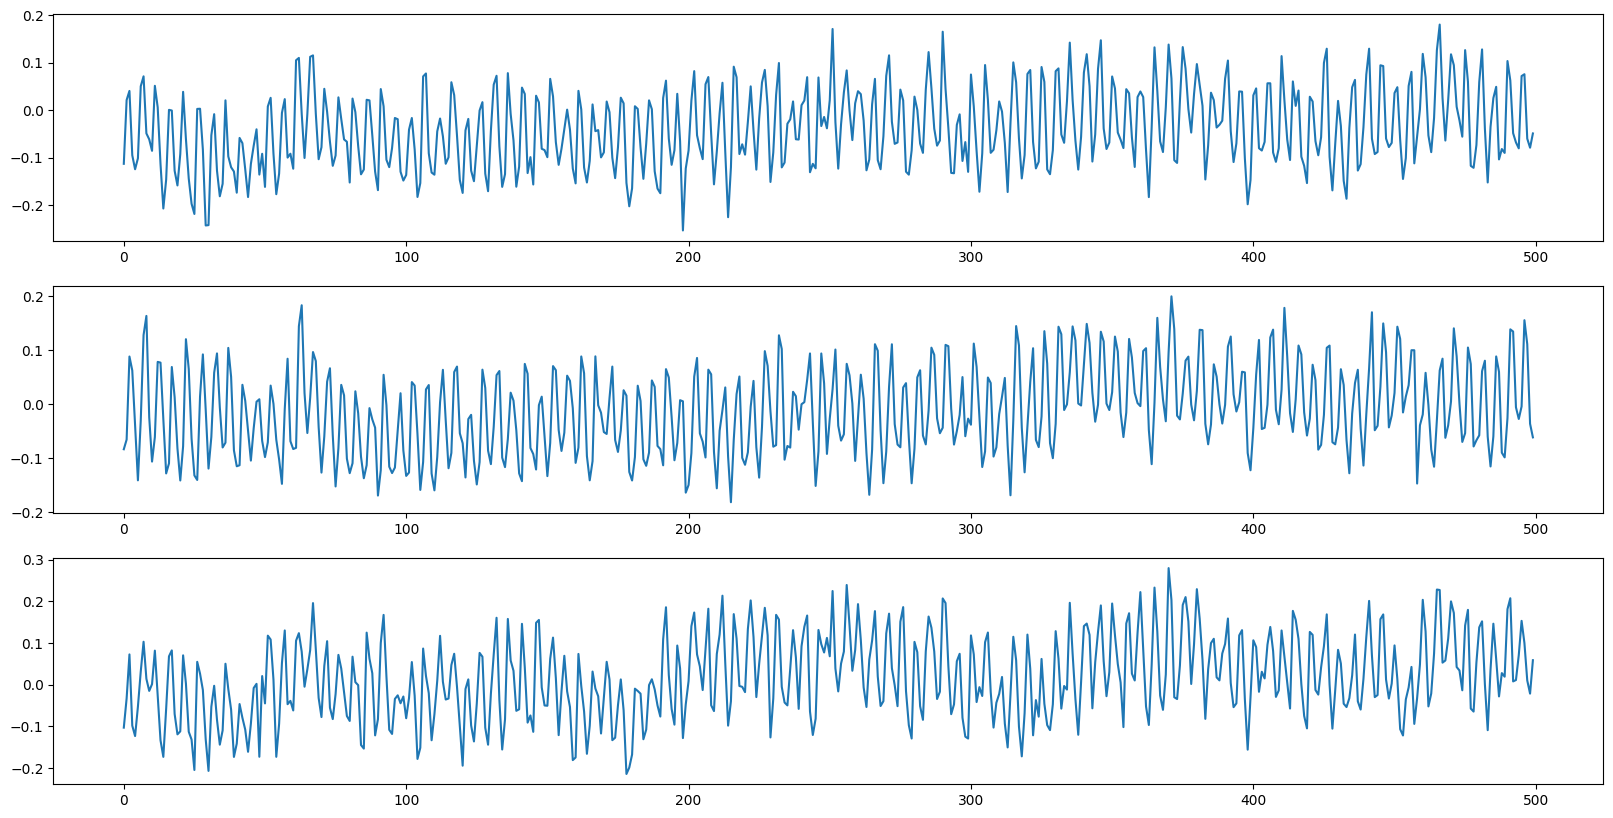

In [6]:
X_normalized = normalize(X, np.min(X), np.max(X))

#plot the first three channels
fig, ax = plt.subplots(3,1, figsize=(20,10))
x = np.arange(500)
for i in range(len(ax)):
    ax[i].plot(x, X_normalized[i, :])
plt.show()

### 2.2 Bandpass Filtering

#### 2.2.0 Bandpass function

In [7]:
def bandpass_filter(signal: np.array, sample_rate: int = 250, do_filter: bool = True,
                         low_cut=1, high_cut=35, max_cut=45) -> tuple:
    """Performs a bandpass filter on the signal:
    (1) Frequencies above max_cut are removed (power set to zero)
    (2) Between 0 Hz and low_cut and between high_cut and max_cut will be attenuated using a raised cosine filter.
    Between low_cut and high_cut is unchanged.
    """
    assert signal.ndim == 1, "signal should be 1-D"
    assert sample_rate > 0, "sample_rate should be a positive integer in Hz"
    
    # mirror signal to reduce transform artifacts
    signal_mirror = np.append(signal, np.flip(signal))
    
    # fast Fourier transform
    signal_fft = fft.fft(signal_mirror)
    freqs = fft.fftfreq(len(signal_mirror), 1/sample_rate)
    
    if do_filter:
        abs_freqs = np.abs(freqs)
        
        # low-pass filter with raised cosine interpolation between `high_cut` and `max_cut`
        signal_fft[abs_freqs>max_cut] = 0
        interp_range = (abs_freqs>high_cut) & (abs_freqs<=max_cut)
        signal_fft[interp_range] *= 0.5 * (1 + np.cos(np.pi * (abs_freqs[interp_range]-high_cut)/(high_cut-max_cut)))
        
        # high-pass filter
        signal_fft[abs_freqs<low_cut] *= 0.5 * ( 1 + np.cos(np.pi * (abs_freqs[abs_freqs<low_cut]-low_cut)/low_cut))
    
    reconstructed = fft.ifft(signal_fft) # inverse fast Fourier transform
    reconstructed = reconstructed.real # take only real component
    reconstructed = reconstructed[:signal.shape[0]] # undo mirror
    
    # realign means
    reconstructed = reconstructed - np.mean(reconstructed) + np.mean(signal)
    
    return signal_fft, freqs, reconstructed

#### 2.2.1 Bandpass demonstration

Text(0.5, 0.98, 'Signal w/ and w/o Filter')

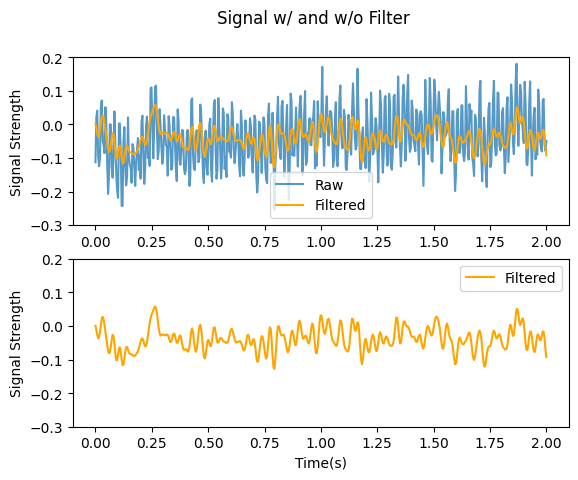

In [8]:
# plot the signal before and after filtering
signal_fft, freqs, reconstructed = bandpass_filter(X_normalized[0, :], sample_rate)
xs = np.linspace(0,2,500)

fig, ax = plt.subplots(2,1)

ax[0].plot(xs, X_normalized[0, :], label="Raw", alpha=0.75)
ax[0].plot(xs, reconstructed, label="Filtered", c='orange')
ax[0].legend()
ax[1].plot(xs, reconstructed, label="Filtered", c='orange')
ax[1].legend()

ax[1].set_xlabel("Time(s)")
for a in ax:
    a.set_ylabel("Signal Strength")
    a.set_ylim(-0.3, 0.2)
    
fig.suptitle("Signal w/ and w/o Filter")

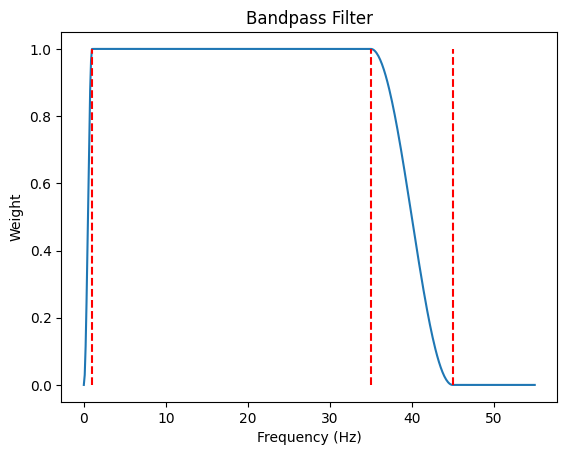

In [9]:
def visualize_filter(low_cut, high_cut, max_cut):
    n = 500
    pad = 20
    xs = np.linspace(0,high_cut+pad, n)
    ys = np.ones(n)
    interp_range = (xs>high_cut) & (xs<=max_cut)
    ys[xs>max_cut] = 0
    ys[interp_range] *= 0.5 * (1 + np.cos(np.pi*(xs[interp_range]-high_cut)/(high_cut-max_cut)))
    ys[xs<low_cut] *= 0.5 * (1+np.cos(np.pi*(xs[xs<low_cut]-low_cut)/low_cut))
    plt.plot(xs, ys)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Weight")
    plt.vlines([low_cut, high_cut, max_cut], 0, 1, colors='red', linestyles='dashed')
    plt.title("Bandpass Filter")
    plt.show()

visualize_filter(1, 35, 45)

Text(0, 0.5, 'Power')

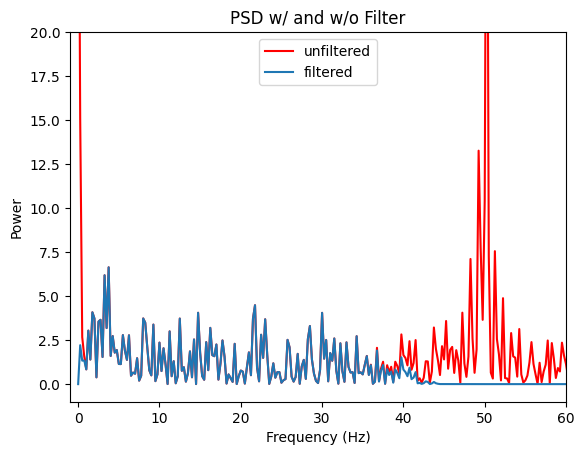

In [10]:
# plot the PSD with and without the bandpass filter
signal_fft_no_filter, _, _ = bandpass_filter(X_normalized[0, :], sample_rate, do_filter=False)

plt.plot(freqs[:500], np.abs(signal_fft_no_filter[:500]), 'r', label='unfiltered')
plt.plot(freqs[:500], np.abs(signal_fft[:500]), label = 'filtered')
plt.xlim(-1,60) # note that at 50 Hz there is major interference, something about AC electrical interference
plt.ylim(-1, 20)
plt.legend()
plt.title('PSD w/ and w/o Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

### 2.3 Signal Decimation

#### 2.3.0 Decimation function

In [11]:
def decimate(signal: np.array, decimation_factor: int) -> np.array:
    """Decimates the time series by `decimation_factor`"""
    assert decimation_factor > 0, "`decimation_factor` must be > 0"
    assert signal.ndim == 1, "`Signal` must be 1D"
    assert signal.shape[0] % decimation_factor == 0, "`Signal` length must be divisible by `decimation factor`"
    return signal[::decimation_factor]
    

#### 2.3.1 Decimation demonstration

Text(0.5, 0.98, 'Signal w/ and w/o Decimation')

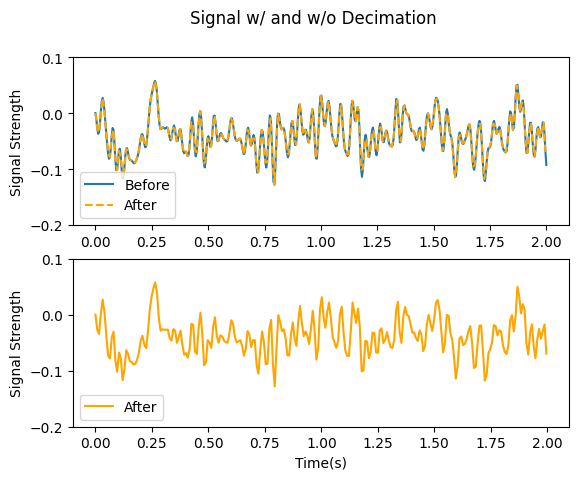

In [12]:
X_decimated = decimate(reconstructed, 2)

fig, ax = plt.subplots(2,1)

ax[0].plot(xs, reconstructed, label="Before")
ax[0].plot(xs[::2], X_decimated, '--', label="After", c='orange')
ax[0].legend()
ax[1].plot(xs[::2], X_decimated, label="After", c='orange')
ax[1].legend()

ax[1].set_xlabel("Time(s)")
for a in ax:
    a.set_ylabel("Signal Strength")
    a.set_ylim(-0.2, 0.1)
    
fig.suptitle("Signal w/ and w/o Decimation")

### 2.4 Truncation

In [13]:
def truncate(signal:np.array, start:int):
    assert signal.ndim == 1, "`signal` must be 1-D"
    assert signal.shape[0] > start and start >= 0, "`start` must be a valid index"
    return signal[start:]

Text(0.5, 0.98, 'Signal w/ and w/o Truncation')

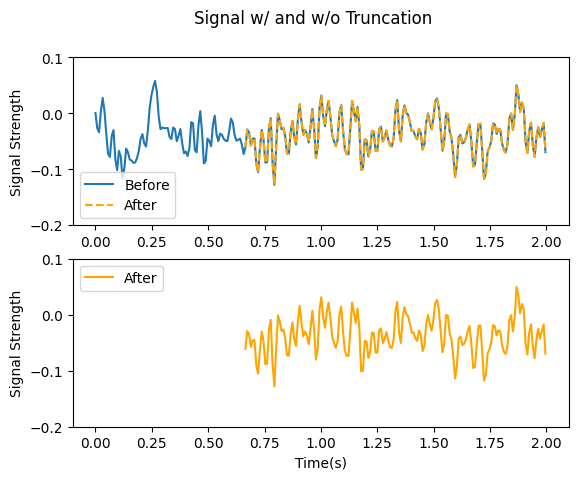

In [14]:
X_truncated = truncate(X_decimated, 250//3)

fig, ax = plt.subplots(2,1)

ax[0].plot(xs[::2], X_decimated, label="Before")
ax[0].plot(xs[::2][250//3:], X_truncated, '--', label="After", c='orange')
ax[0].legend()
ax[1].plot(xs[::2][250//3:], X_truncated, label="After", c='orange')
ax[1].legend()

ax[1].set_xlabel("Time(s)")
for a in ax:
    a.set_ylabel("Signal Strength")
    a.set_ylim(-0.2, 0.1)
    a.set_xlim(-0.1, 2.1)
    
fig.suptitle("Signal w/ and w/o Truncation")

### 2.5 Full Pipeline
#### 2.5.1 Pipeline Function

In [15]:
def pipeline_factory(sample_rate: int = 250, do_filter: bool = True, low_cut=1, high_cut=35, max_cut=45,
                 decimation_factor: int = 2,
                 start: int = 250//3):
    
    def pipeline(signal: np.array) -> np.array:
        # We'll skip normalization for now -- it's better to do it after bandpass
        # because bandpass tends to reduce the amplitude of the signal,
        # but that makes it annoying to estimate min & max values when streaming the big dataset.
        # Instead, we'll use a Rescaling layer in our neural network models
        
        _, _, signal = bandpass_filter(signal, sample_rate, do_filter, low_cut, high_cut, max_cut)
        signal = decimate(signal, decimation_factor)
        signal = truncate(signal, start)

        return signal
    
    return pipeline

#### 2.5.2 Pipeline Demonstration

#### 2.5.3 Different cuts

Text(0.5, 0.98, 'Signal w/ and w/o Pipeline')

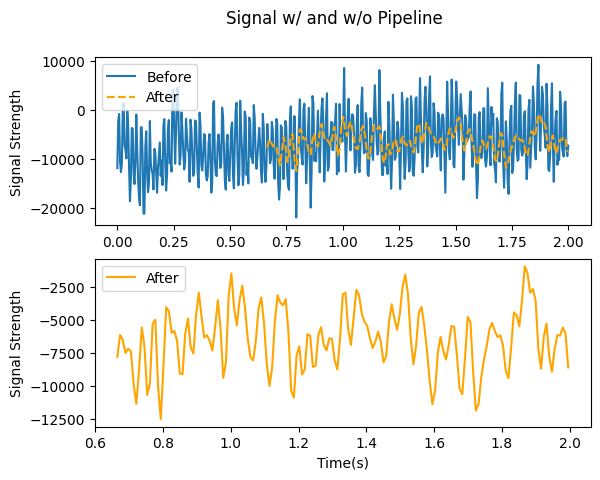

In [16]:
pipeline = pipeline_factory(high_cut=30, max_cut=40)

X_processed = pipeline(X[0,:])
xs = np.linspace(0,2,500)

fig, ax = plt.subplots(2,1)

ax[0].plot(xs, X[0,:], label="Before")
ax[0].plot(xs[::2][250//3:], X_processed, '--', label="After", c='orange')
ax[0].legend()
ax[1].plot(xs[::2][250//3:], X_processed, label="After", c='orange')
ax[1].legend()

ax[1].set_xlabel("Time(s)")
for a in ax:
    a.set_ylabel("Signal Strength")
    
fig.suptitle("Signal w/ and w/o Pipeline")

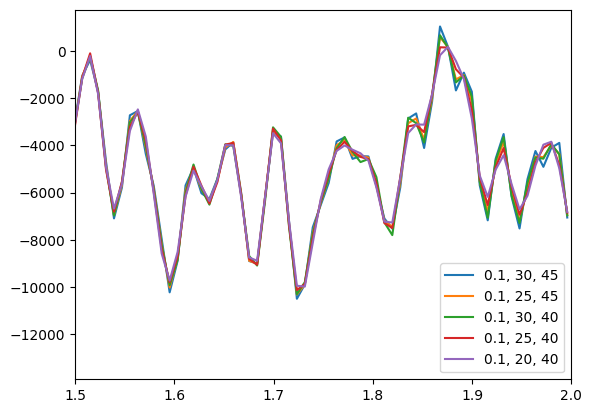

In [17]:
xs = np.linspace(0,2,500)[::2][250//3:]

pipeline = pipeline_factory(low_cut=0.1, high_cut=30, max_cut=45)
X_processed = pipeline(X[0,:])
plt.plot(xs, X_processed, label='0.1, 30, 45')

pipeline = pipeline_factory(low_cut=0.1, high_cut=25, max_cut=45)
X_processed = pipeline(X[0,:])
plt.plot(xs, X_processed, label='0.1, 25, 45')

pipeline = pipeline_factory(low_cut=0.1, high_cut=30, max_cut=40)
X_processed = pipeline(X[0,:])
plt.plot(xs, X_processed, label='0.1, 30, 40')

pipeline = pipeline_factory(low_cut=0.1, high_cut=25, max_cut=40)
X_processed = pipeline(X[0,:])
plt.plot(xs, X_processed, label='0.1, 25, 40')

pipeline = pipeline_factory(low_cut=0.1, high_cut=20, max_cut=40)
X_processed = pipeline(X[0,:])
plt.plot(xs, X_processed, label='0.1, 20, 40')

plt.legend()
plt.xlim(1.5,2)
plt.show()

## 3.0 Apply to csv

In [18]:
from typing import Callable
import gzip
def pipe_csv_in_chunks(pipeline: Callable, input_csv: str, output_csv:str, filesize:int, headers:list,
                          num_channels: int = 128, sample_rate: int = 250, sample_duration: int = 2, 
                          chunksize:int=1000,
                          drop_negatives=False):
    # Open input and output CSV files
    with open(input_csv, 'r') as f_in, gzip.open(output_csv+'.gz', 'wt', newline='') as f_out:
        reader = csv.reader(f_in)
        writer = csv.writer(f_out)
        writer.writerow(headers)
        
        # keep track of min and max after processing
        min_ = float('inf')
        max_ = -float('inf')
        
        # useful variables
        tsteps = sample_rate * sample_duration
        channel_names = [elec+f"_{i}" for elec in electrode_names for i in range(sample_rate * sample_duration)]        
        # Process the CSV file in chunks
        for chunk in tqdm(pd.read_csv(f_in, header=0, chunksize=chunksize), total=filesize//chunksize):
            for index, row in chunk.iterrows():
                # extract signals
                row_array = row.loc[channel_names].to_numpy()
                signals = [row_array[tsteps*i:tsteps*(i+1)] for i in range(num_channels)]
                
                # process signals
                processed_signals = np.concatenate([pipeline(signal) for signal in signals])
                
                # update min and max
                min_ = min(min_, np.min(processed_signals))
                max_ = max(max_, np.max(processed_signals))
                
                # extract label
                label = row.loc[['label', 'label_pos']].to_numpy()
                # label_pos is the ID of the image in the MNIST dataset
                
                # Write the parsed row to the output CSV
                parsed_row = np.append(processed_signals, label).astype(np.int32)
                # rounding to int should be ok... most values are in the thousands
                writer.writerow(parsed_row.tolist())

        return min_, max_

In [19]:
# prepare to process csv
pipeline = pipeline_factory(low_cut=0.1, high_cut=30, max_cut=45)

# make headers list
post_len = int(sample_rate * sample_duration / 2 - 250//3)
# original length divided by decimationg factor minus truncation
headers = [elec+f"_{i}" for elec in electrode_names for i in range(post_len)] + ['label', 'label_pos']

In [20]:
# testing data (don't care about min and max)
# _, _ = pipe_csv_in_chunks(pipeline, '/kaggle/input/mindbigdata2023-mnist-8b/test.csv',
#                                '/kaggle/working/processed_test.csv', 20000,
#                                 headers=headers, chunksize=1000)

In [21]:
# training data
min_, max_ = pipe_csv_in_chunks(pipeline, '/kaggle/input/mindbigdata2023-mnist-8b/train.csv',
                               '/kaggle/working/processed_train.csv', 120000,
                                headers=headers, chunksize=1000)

100%|██████████| 120/120 [9:45:23<00:00, 292.70s/it]


In [22]:
print("(Min, Max):")
print((min_, max_))

(Min, Max):
(-645188.5048148541, 633405.4000618928)
